In [33]:
import numpy as np
import csv
import glob
import os.path
from os import path
from datetime import datetime
import matplotlib.pyplot as plt
import talib

In [34]:
# The basic CSV instrument. We'll abstract this later when we need it
class FileInstrument:
    def __init__(self, filename, load=True):
        self.datetime_format = '%d-%b-%Y'
        self.column_names = ['day', 'month', 'year', 'open', 'high', 'low', 'close', 'volume', 'forward_returns']
        self.column_set = set(self.column_names)
        
        self.data = None
        
        if load:
            self.load_file(filename)
        
    def load_file(self, filename):
        with open(filename) as f:
            item = []
            reader = csv.reader(f)
            for row in reader:
                _row = self.format_row(*row)
                item.append(_row)
                
        item = np.array(item)
        returns = np.expand_dims(np.diff(item[:,-2], append=item[:,-2][-1]), axis=1)
        
        items_with_returns = np.hstack((item, returns))
        self.data = items_with_returns
        
    def format_row(self, *args):
        date = datetime.strptime(args[0], self.datetime_format)
        o = float(args[1])
        h = float(args[2])
        l = float(args[3])
        c = float(args[4])
        v = int(args[5])

        return [date.day, date.month, date.year, o, h, l, c, v]
    
    def attach_feature(self, feature, name):
        self.column_set.add(name) # this will fail if the feature already exists
        self.column_names.append(name)
        
        f = np.expand_dims(feature, axis=1)
        self.data = np.hstack((self.data, f))
    
    def __getitem__(self, key):
        if type(key) == str:
            idx = self.column_names.index(key)
            return self.data[:,idx]
        
        return self.data.__getitem__(key)

    def __repr__(self):
        return self.data.__repr__()

In [102]:
def monte_carlo(asset, strategy, samples=1000, simulations=999):
    returns = asset['forward_returns'][strategy]
    mcs = np.stack([np.cumsum(np.random.choice(returns, samples)) for i in range(simulations)])
    return mcs

In [36]:
def performance(asset, strategy):
    return strategy.astype(int) * asset['forward_returns']

In [37]:
# Takes an individual set of returns and returns the cumulative drawdown
def drawdown(equity_curve):
    return equity_curve / np.maximum.accumulate(equity_curve)

# Takes a monte carlo strawbrook and returns the worst drawdown possible
def worst_drawdown(strawbroom):
    return drawdown(np.min(mc, axis=0))

In [38]:
# Calculates the worst drawdown given a strawbroom and then pads 
# it so the drawdown is never below the provided risk tolerance
def optimal_starting_portfolio(strawbroom, personal_risk_tolerance):
    pass

In [39]:
def mean_confidence_interval(data, confidence=0.997):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [40]:
# print(f'Time in the market: \t\t{time_in_market*100:.2f}%')
# print(f'Performance against BH: \t{strat_v_bh*100:.2f}%')
# print(f'Volatility efficiency: \t\t{(strat_v_bh / time_in_market)*100:.2f}%')

In [41]:
aapl = FileInstrument('../../../Developer/Data/prices/NASDAQ/AAPL.csv')

In [42]:
perc_diff = (aapl['close'][1:] / aapl['close'][:-1])

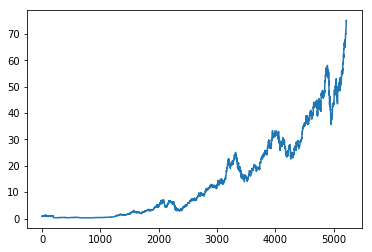

In [43]:
plt.plot(np.cumprod(perc_diff))

In [44]:
d = np.diff(aapl['close'], prepend=aapl['close'][0])
aapl.attach_feature(d, 'back_returns')

In [45]:
aapl

array([[ 3.00000e+00,  1.00000e+00,  2.00000e+03, ...,  1.91364e+07,
        -3.37100e-01,  0.00000e+00],
       [ 4.00000e+00,  1.00000e+00,  2.00000e+03, ...,  1.82760e+07,
         5.36000e-02, -3.37100e-01],
       [ 5.00000e+00,  1.00000e+00,  2.00000e+03, ...,  2.77972e+07,
        -3.21400e-01,  5.36000e-02],
       ...,
       [ 2.00000e+00,  1.00000e+00,  2.02000e+03, ...,  3.39118e+07,
        -2.92000e+00,  6.70000e+00],
       [ 3.00000e+00,  1.00000e+00,  2.02000e+03, ...,  3.66338e+07,
         2.37000e+00, -2.92000e+00],
       [ 6.00000e+00,  1.00000e+00,  2.02000e+03, ...,  2.96446e+07,
         0.00000e+00,  2.37000e+00]])

In [103]:
mc = monte_carlo(aapl, aapl['back_returns'] > talib.EMA(aapl['back_returns'], timeperiod=100))

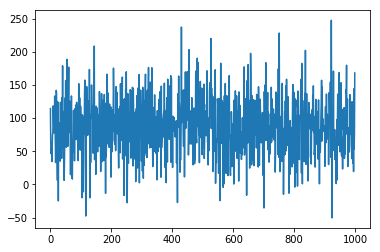

In [52]:
plt.plot(mc.T[-1])

In [95]:
import scipy.stats
confidence = 0.997
a = 1.0 * np.array(mc)
n = len(a)
m, se = np.mean(a, axis=0), scipy.stats.sem(a, axis=0)
h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
x = np.vstack((m, m-h, m+h))

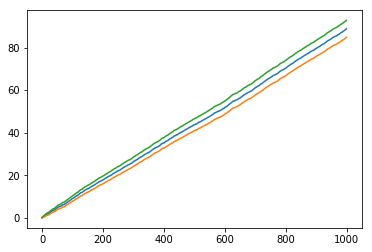

In [92]:
plt.plot(x.T)

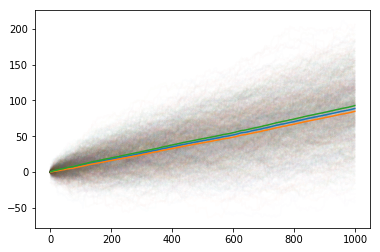

In [93]:
plt.plot(mc.T, alpha=0.01)
plt.plot(x.T)

In [82]:
mc = monte_carlo(aapl, aapl['back_returns'] > talib.EMA(aapl['back_returns']), simulations=10)

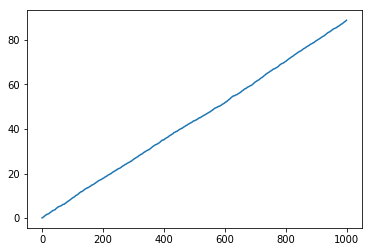

In [98]:
plt.plot(np.mean(mc, axis=0))

In [132]:
confidence = 0.999

In [133]:
len(mc)

999

In [145]:
upper_3 = np.mean(mc, axis=0) + (3 * np.std(mc, axis=0))
lower_3 = np.mean(mc, axis=0) - (3 * np.std(mc, axis=0))

upper_2 = np.mean(mc, axis=0) + (2 * np.std(mc, axis=0))
lower_2 = np.mean(mc, axis=0) - (2 * np.std(mc, axis=0))

upper_1 = np.mean(mc, axis=0) + (1 * np.std(mc, axis=0))
lower_1 = np.mean(mc, axis=0) - (1 * np.std(mc, axis=0))

bands = np.stack((upper_3, upper_2, upper_1, lower_1, lower_2, lower_3))

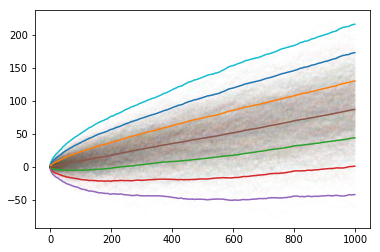

In [146]:
plt.plot(mc.T, alpha=0.01)
plt.plot(bands.T)
plt.plot(np.mean(mc, axis=0))